In [1]:
# import necessary module
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import scipy
from array_response import *
import itertools 

from IPython.display import Image


### Parameters declaration

Declare parameters needed for channel realization

In [2]:
Ns = 1 # number of streams

Nc = 6 # number of cluster
Nray = 3 # number of rays in each cluster

Nt = 64 # number of transmit antennas
Nr = 16 # number of receive antennas

angle_sigma = 10/180*np.pi # standard deviation of the angles in azimuth and elevation both of Rx and Tx

gamma = np.sqrt((Nt*Nr)/(Nc*Nray))
realization = 1000 # equivalent to number of taking sample
count = 0

eps = 0.1 # 20dB isolation
sigma = np.sqrt(8/(1+eps**2)) # according to the normalization condition of H


### Channel Realization

Realize channel H for Dual-Polarized antenna array

In [3]:
H_pol = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
At = np.zeros((Nt,Nc*Nray,realization),dtype=complex)
Ar = np.zeros((Nr,Nc*Nray,realization),dtype=complex)
alpha_hh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_hv = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vh = np.zeros((Nc*Nray,realization),dtype=complex)
alpha_vv = np.zeros((Nc*Nray,realization),dtype=complex)

AoD = np.zeros((2,Nc*Nray),dtype=complex)
AoA = np.zeros((2,Nc*Nray),dtype=complex)

H = np.zeros((2*Nr,2*Nt,realization),dtype=complex)
azi_rot = np.random.uniform(0,2*np.pi,realization)
ele_rot = np.random.uniform(0,np.pi/2,realization) # Why PI/2 ??
R = np.array([[np.cos(ele_rot)*np.cos(azi_rot),np.sin(ele_rot)],[-np.sin(ele_rot)*np.cos(azi_rot),np.cos(ele_rot)]]) # rotation matrix

for reali in range(realization):
    for c in range(1,Nc+1):
        AoD_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Departure _ azimuth
        AoD_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Departure _ elevation
        AoA_azi_m = np.random.uniform(0,2*np.pi,1) # Mean Angle of Arrival_ azimuth
        AoA_ele_m = np.random.uniform(0,np.pi,1) # Mean Angle of Arrival_ elevation
        AoD[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_azi_m, angle_sigma, (1,Nray))
        AoD[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoD_ele_m, angle_sigma, (1,Nray))
        AoA[0,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_azi_m, angle_sigma, (1,Nray))
        AoA[1,(c-1)*Nray:Nray*c] = np.random.laplace(AoA_ele_m, angle_sigma, (1,Nray))
    for j in range(Nc*Nray):
        At[:,j,reali] = array_response(AoD[0,j],AoD[1,j],Nt) # UPA array response
        Ar[:,j,reali] = array_response(AoA[0,j],AoA[1,j],Nr)
        var_hh = ((sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_hv = ((eps**2)*(sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[0,j])**2)).real
        var_vh = ((eps**2)*(sigma**2)*(np.cos(AoD[0,j])**2)*(np.cos(AoA[1,j])**2)).real
        var_vv = ((sigma**2)*(np.cos(AoD[1,j])**2)*(np.cos(AoA[1,j])**2)).real
        alpha_hh[j,reali] = np.random.normal(0, np.sqrt(var_hh/2)) + 1j*np.random.normal(0, np.sqrt(var_hh/2))
        alpha_hv[j,reali] = np.random.normal(0, np.sqrt(var_hv/2)) + 1j*np.random.normal(0, np.sqrt(var_hv/2))
        alpha_vh[j,reali] = np.random.normal(0, np.sqrt(var_vh/2)) + 1j*np.random.normal(0, np.sqrt(var_vh/2))
        alpha_vv[j,reali] = np.random.normal(0, np.sqrt(var_vv/2)) + 1j*np.random.normal(0, np.sqrt(var_vv/2))
        alpha = np.vstack((np.hstack((alpha_hh[j,reali],alpha_hv[j,reali])),np.hstack((alpha_vh[j,reali],alpha_vv[j,reali]))))
        H_pol[:,:,reali] = H_pol[:,:,reali] + np.kron(alpha,Ar[:,[j],reali]@At[:,[j],reali].conj().T)
    H_pol[:,:,reali] = gamma* H_pol[:,:,reali]
    H[:,:,reali] = (np.kron(R[:,:,reali],np.eye(Nr)))@H_pol[:,:,reali]
    H[:,:,reali] = np.sqrt(4/3)* H[:,:,reali]


### Check normalized condition

In [4]:
channel_fro_1 = np.zeros(realization)
for reali in range(realization):
    channel_fro_1[reali] = np.linalg.norm(H_pol[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm H pol=", np.mean(channel_fro_1**2))

4*Nt*Nr = 4096    Frobenius norm H pol= 4111.107947683633


In [5]:
channel_fro_2 = np.zeros(realization)
for reali in range(realization):
    channel_fro_2[reali] = np.linalg.norm(H[:,:,reali],'fro')
print("4*Nt*Nr =", 4*Nt*Nr , "   Frobenius norm =", np.mean(channel_fro_2**2))

4*Nt*Nr = 4096    Frobenius norm = 4124.554594342982


### Joint Horizontal/Vertical Beamformer Selection

| hori_tx | hori_rx | verti_tx | verti_rx |
|:--------|--------|--------:|:---------:|

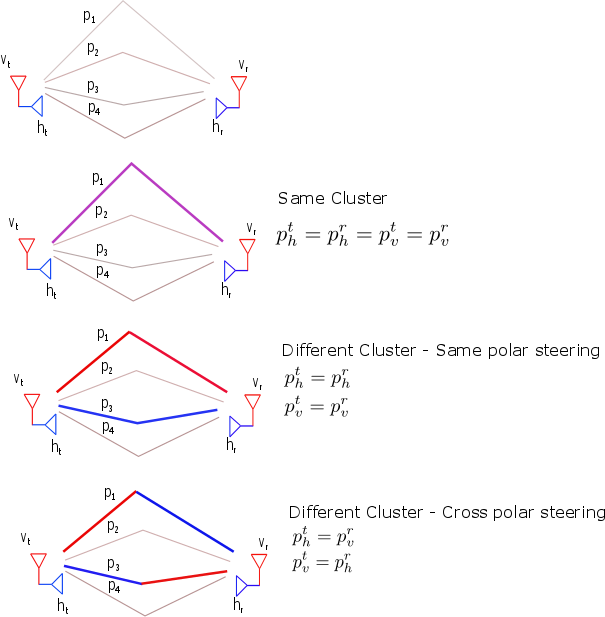

In [6]:
Image("img/cluster.png")

### Histogram of chosen path

__path gain of each combination__

Numpath = number of total combination

path_combi = arrangement of combination

In [8]:
total_combi = Nc*Nray
cluster = np.arange(total_combi)
print(cluster)
c = list(itertools.combinations(cluster, 2))
num_path = (2*total_combi-1)*total_combi
path_combi = np.zeros((num_path,4),dtype=int)

print(path_combi.shape)
path_combi[0:total_combi,:]=np.arange(total_combi).reshape(total_combi,1).repeat(4,axis=1)

count = 0
for i in range(int(total_combi*(total_combi-1)/2)):
    path_combi[total_combi+4*i,:] = np.array([c[count][0],c[count][0],c[count][1],c[count][1]])
    path_combi[total_combi+4*i+1,:] = np.array([c[count][1],c[count][1],c[count][0],c[count][0]])
    path_combi[total_combi+4*i+2,:] = np.array([c[count][0],c[count][1],c[count][1],c[count][0]])
    path_combi[total_combi+4*i+3,:] = np.array([c[count][1],c[count][0],c[count][0],c[count][1]])
    count = count+1
# print(path_combi[0:10,:])
path_gain = np.zeros((num_path,realization)) # 2 to save the position and maximum value
for reali in range(realization):
    for combi in range(num_path):
        path_gain[combi,reali] =\
        (np.abs\
         ((np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.sin(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,1])+\
         (np.cos(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.sin(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,1])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hh[path_combi[combi,0],reali]+np.cos(ele_rot[reali])*alpha_vh[path_combi[combi,0],reali])*(path_combi[combi,0]==path_combi[combi,3])+\
         (-np.sin(ele_rot[reali])*np.cos(azi_rot[reali])*alpha_hv[path_combi[combi,2],reali]+np.cos(ele_rot[reali])*alpha_vv[path_combi[combi,2],reali])*(path_combi[combi,2]==path_combi[combi,3])
         ))**2


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
(630, 4)


In [9]:
print(num_path)
print(path_gain.shape)
print(alpha_hh.shape)

630
(630, 1000)
(18, 1000)


__Check maximum gain from combination of path in each realization__

To do the joint polar beam steering later

In [10]:
index = np.zeros(realization,dtype=int)
for reali in range(realization):
    index[reali] = np.argmax(path_gain[:,reali])


__Create the Cross and Co Polar Index__

In [11]:
cross_index =  []
samepolar_index = []
count = total_combi-1
while (count<num_path-4):
    cross_index.extend([count+3,count+4])
    samepolar_index.extend([count+1,count+2])
    count = count + 4
cross_index = np.array(cross_index)
samepolar_index = np.array(samepolar_index)
sameclus_index = np.arange(0,total_combi)
print(cross_index)
print(samepolar_index)
print(sameclus_index)

[ 20  21  24  25  28  29  32  33  36  37  40  41  44  45  48  49  52  53
  56  57  60  61  64  65  68  69  72  73  76  77  80  81  84  85  88  89
  92  93  96  97 100 101 104 105 108 109 112 113 116 117 120 121 124 125
 128 129 132 133 136 137 140 141 144 145 148 149 152 153 156 157 160 161
 164 165 168 169 172 173 176 177 180 181 184 185 188 189 192 193 196 197
 200 201 204 205 208 209 212 213 216 217 220 221 224 225 228 229 232 233
 236 237 240 241 244 245 248 249 252 253 256 257 260 261 264 265 268 269
 272 273 276 277 280 281 284 285 288 289 292 293 296 297 300 301 304 305
 308 309 312 313 316 317 320 321 324 325 328 329 332 333 336 337 340 341
 344 345 348 349 352 353 356 357 360 361 364 365 368 369 372 373 376 377
 380 381 384 385 388 389 392 393 396 397 400 401 404 405 408 409 412 413
 416 417 420 421 424 425 428 429 432 433 436 437 440 441 444 445 448 449
 452 453 456 457 460 461 464 465 468 469 472 473 476 477 480 481 484 485
 488 489 492 493 496 497 500 501 504 505 508 509 51

In [28]:
cross_index_in = np.isin(index, cross_index)
print('Number of Cross Index chosen in 1000 realization: ',sum(cross_index_in))
samepolar_index_in = np.isin(index, samepolar_index)
print('Number of Same Polar Index chosen in 1000 realization: ',sum(samepolar_index_in))
print('Number of Same Cluster Index chosen in 1000 realization: ',1000 - sum(samepolar_index_in) - sum(cross_index_in))

Number of Cross Index chosen in 1000 realization:  236
Number of Same Polar Index chosen in 1000 realization:  262
Number of Same Cluster Index chosen in 1000 realization:  502


__Plot Distribution of Index Chosen__

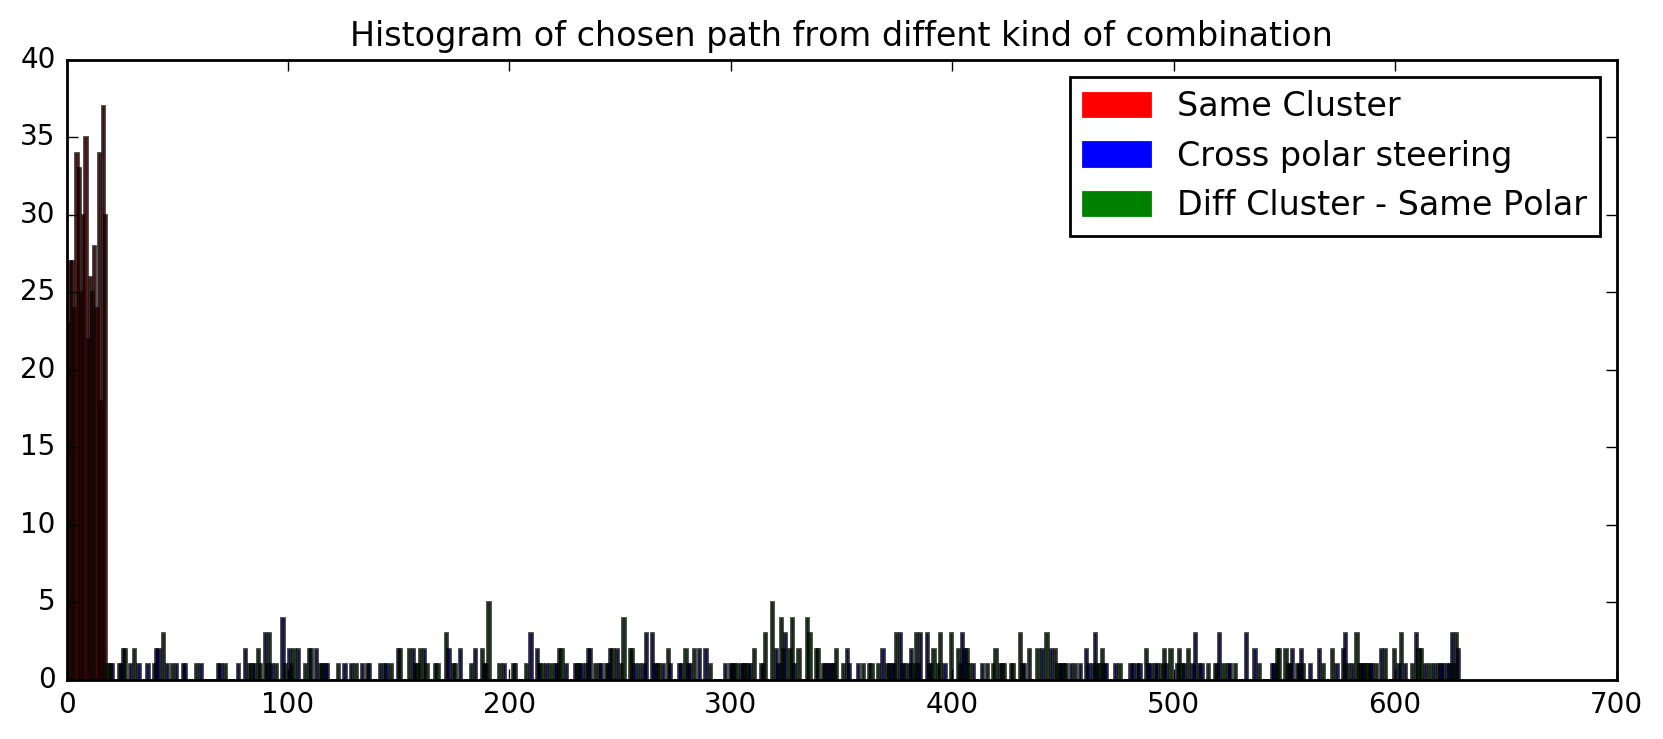

In [13]:
fig = plt.figure(figsize=(10,4), dpi=200)
n, bins, patches = plt.hist(index, bins=range(0,num_path+1),facecolor='green', alpha=0.75)
# ,edgecolor='black'
# print(n.shape)
# print(bins.shape)
# print(n)
# print(bins)

for i in range(0,total_combi):
    patches[i].set_fc('r')
for j in cross_index:
    patches[j].set_fc('b')
    
cluster_same = mpatches.Patch(color='red', label='Same Cluster')
cross_polar = mpatches.Patch(color='blue', label='Cross polar steering')
diff_clus_same_polar = mpatches.Patch(color='green', label='Diff Cluster - Same Polar')

plt.legend(handles=[cluster_same,cross_polar,diff_clus_same_polar])
plt.title('Histogram of chosen path from diffent kind of combination')
plt.show()


In [14]:
unique, counts = np.unique(index, return_counts=True)
print(dict(zip(unique, counts)))


{0: 23, 1: 27, 2: 27, 3: 24, 4: 34, 5: 33, 6: 25, 7: 30, 8: 35, 9: 22, 10: 26, 11: 25, 12: 28, 13: 24, 14: 34, 15: 18, 16: 37, 17: 30, 18: 1, 19: 1, 20: 1, 23: 1, 24: 1, 25: 2, 26: 2, 28: 1, 30: 2, 32: 1, 36: 1, 39: 1, 40: 2, 41: 2, 43: 3, 45: 1, 47: 1, 49: 1, 52: 1, 53: 1, 58: 1, 60: 1, 68: 1, 69: 1, 71: 1, 77: 1, 80: 2, 82: 1, 83: 1, 84: 1, 86: 2, 87: 1, 89: 3, 90: 1, 91: 3, 92: 1, 94: 1, 97: 4, 98: 1, 100: 2, 101: 1, 102: 2, 104: 2, 107: 1, 109: 2, 110: 2, 112: 2, 114: 1, 115: 1, 116: 1, 117: 1, 122: 1, 125: 1, 128: 1, 130: 1, 133: 1, 135: 1, 136: 1, 141: 1, 143: 1, 144: 1, 146: 1, 149: 2, 150: 2, 154: 2, 156: 2, 157: 1, 158: 1, 159: 2, 161: 2, 162: 1, 166: 1, 167: 1, 171: 3, 172: 2, 174: 1, 175: 1, 177: 2, 182: 1, 184: 2, 187: 2, 188: 1, 189: 1, 190: 5, 195: 1, 197: 1, 201: 1, 202: 1, 207: 1, 209: 3, 212: 2, 213: 1, 214: 1, 216: 1, 218: 1, 220: 1, 221: 1, 222: 2, 223: 2, 225: 1, 229: 1, 230: 1, 231: 1, 232: 1, 234: 1, 235: 2, 236: 2, 238: 1, 240: 1, 241: 1, 243: 1, 244: 1, 245: 2, 

### Distribution of each kind of combination by simulation

__Index of Same Cluster Max__

In [15]:
index_sameclus = np.zeros(realization,dtype=int)
for reali in range(realization):
    index_sameclus[reali] = np.argmax(path_gain[0:total_combi,reali])

In [16]:
gain_sameclus = np.zeros(realization,dtype=float)
for reali in range(realization):
    gain_sameclus[reali] = path_gain[index_sameclus[reali],reali]

__Index of Different Cluster-Cross Polar Max__

In [17]:
cross_index

array([ 20,  21,  24,  25,  28,  29,  32,  33,  36,  37,  40,  41,  44,
        45,  48,  49,  52,  53,  56,  57,  60,  61,  64,  65,  68,  69,
        72,  73,  76,  77,  80,  81,  84,  85,  88,  89,  92,  93,  96,
        97, 100, 101, 104, 105, 108, 109, 112, 113, 116, 117, 120, 121,
       124, 125, 128, 129, 132, 133, 136, 137, 140, 141, 144, 145, 148,
       149, 152, 153, 156, 157, 160, 161, 164, 165, 168, 169, 172, 173,
       176, 177, 180, 181, 184, 185, 188, 189, 192, 193, 196, 197, 200,
       201, 204, 205, 208, 209, 212, 213, 216, 217, 220, 221, 224, 225,
       228, 229, 232, 233, 236, 237, 240, 241, 244, 245, 248, 249, 252,
       253, 256, 257, 260, 261, 264, 265, 268, 269, 272, 273, 276, 277,
       280, 281, 284, 285, 288, 289, 292, 293, 296, 297, 300, 301, 304,
       305, 308, 309, 312, 313, 316, 317, 320, 321, 324, 325, 328, 329,
       332, 333, 336, 337, 340, 341, 344, 345, 348, 349, 352, 353, 356,
       357, 360, 361, 364, 365, 368, 369, 372, 373, 376, 377, 38

In [18]:
index_diffclus_crosspol = np.zeros(realization,dtype=int)
for reali in range(realization):
    index_diffclus_crosspol[reali] = np.argmax(path_gain[cross_index,reali])

In [19]:
gain_diffclus_crosspol = np.zeros(realization,dtype=float)
for reali in range(realization):
    gain_diffclus_crosspol[reali] = path_gain[cross_index[np.argmax(path_gain[cross_index,reali])],reali]

__Index of Different Cluster-Same Polar Max__

In [20]:
samepolar_index

array([ 18,  19,  22,  23,  26,  27,  30,  31,  34,  35,  38,  39,  42,
        43,  46,  47,  50,  51,  54,  55,  58,  59,  62,  63,  66,  67,
        70,  71,  74,  75,  78,  79,  82,  83,  86,  87,  90,  91,  94,
        95,  98,  99, 102, 103, 106, 107, 110, 111, 114, 115, 118, 119,
       122, 123, 126, 127, 130, 131, 134, 135, 138, 139, 142, 143, 146,
       147, 150, 151, 154, 155, 158, 159, 162, 163, 166, 167, 170, 171,
       174, 175, 178, 179, 182, 183, 186, 187, 190, 191, 194, 195, 198,
       199, 202, 203, 206, 207, 210, 211, 214, 215, 218, 219, 222, 223,
       226, 227, 230, 231, 234, 235, 238, 239, 242, 243, 246, 247, 250,
       251, 254, 255, 258, 259, 262, 263, 266, 267, 270, 271, 274, 275,
       278, 279, 282, 283, 286, 287, 290, 291, 294, 295, 298, 299, 302,
       303, 306, 307, 310, 311, 314, 315, 318, 319, 322, 323, 326, 327,
       330, 331, 334, 335, 338, 339, 342, 343, 346, 347, 350, 351, 354,
       355, 358, 359, 362, 363, 366, 367, 370, 371, 374, 375, 37

In [21]:
index_diffclus_samepol = np.zeros(realization,dtype=int)
for reali in range(realization):
    index_diffclus_samepol[reali] = np.argmax(path_gain[samepolar_index,reali])

In [22]:
gain_diffclus_samepol = np.zeros(realization,dtype=float)
for reali in range(realization):
    gain_diffclus_samepol[reali] = path_gain[samepolar_index[np.argmax(path_gain[samepolar_index,reali])],reali]

### Plot the Distribution

Average of Same Cluster Gain Distribution: 20.34225676703441
Average of Different Cluster - Cross polar Gain Distribution: 11.994130235085715
Average of Different Cluster - Same polar Gain Distribution: 13.079579300486673


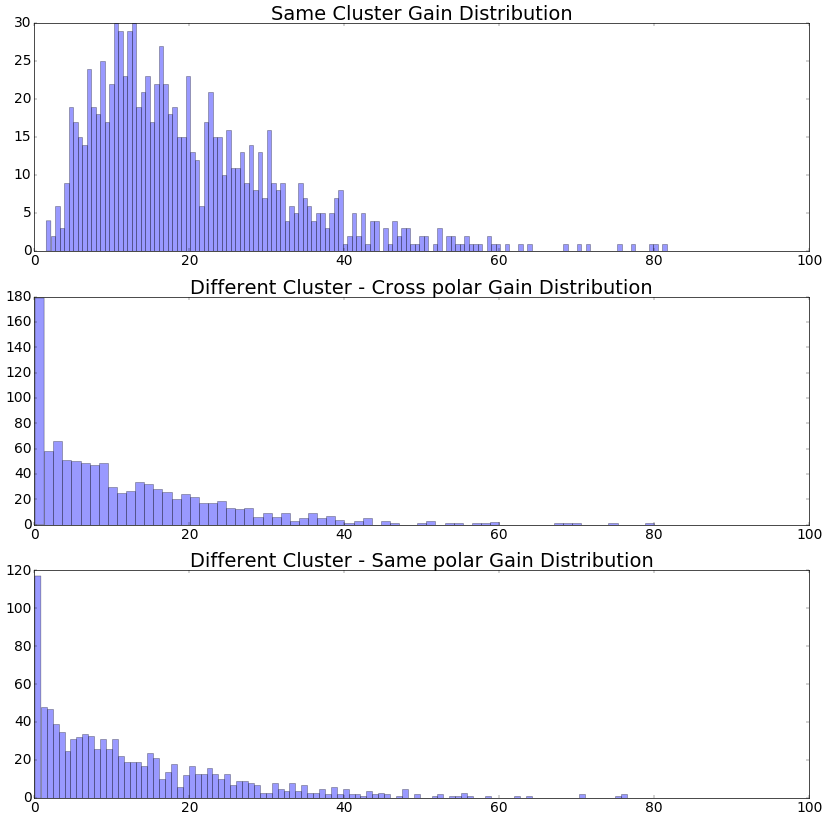

In [23]:
fig = plt.figure(figsize=(20,20), dpi=50)

plt.subplot(3, 1, 1)
plt.title('Same Cluster Gain Distribution', fontsize = 28)
sns.distplot(gain_sameclus,bins=180, kde = False)
plt.xlim(0,100)
plt.tick_params(axis='both', which='major', labelsize=20)
print('Average of Same Cluster Gain Distribution:',np.mean(gain_sameclus))

plt.subplot(3, 1, 2)
plt.title('Different Cluster - Cross polar Gain Distribution', fontsize = 28)
sns.distplot(gain_diffclus_crosspol,bins=100, kde = False)
plt.xlim(0,100)
plt.tick_params(axis='both', which='major', labelsize=20)
print('Average of Different Cluster - Cross polar Gain Distribution:',np.mean(gain_diffclus_crosspol))

plt.subplot(3, 1, 3)
plt.title('Different Cluster - Same polar Gain Distribution', fontsize = 28)
sns.distplot(gain_diffclus_samepol,bins=100, kde = False)
plt.xlim(0,100)
plt.tick_params(axis='both', which='major', labelsize=20)
print('Average of Different Cluster - Same polar Gain Distribution:',np.mean(gain_diffclus_samepol))

In [24]:
# fig = plt.figure(figsize=(20,20), dpi=50)

# plt.subplot(2, 1, 1)
# plt.title('Same Cluster - Different Cluster Cross polar', fontsize = 28)
# sns.distplot(gain_sameclus-gain_diffclus_crosspol,bins=180, kde = False)
# plt.xlim(-50,100)
# plt.tick_params(axis='both', which='major', labelsize=20)
# print('Average of Same Cluster Gain Distribution:',np.mean(gain_sameclus))

# plt.subplot(2, 1, 2)
# plt.title('Different Cluster - Cross polar Gain Distribution', fontsize = 28)
# sns.distplot(gain_sameclus-gain_diffclus_samepol,bins=100, kde = False)
# plt.xlim(-50,100)
# plt.tick_params(axis='both', which='major', labelsize=20)
# print('Average of Different Cluster - Cross polar Gain Distribution:',np.mean(gain_sameclus-gain_diffclus_crosspol))
# print(np.count_nonzero(gain_sameclus>gain_diffclus_crosspol)/1000)
# print(np.count_nonzero(gain_sameclus>gain_diffclus_samepol)/1000)
# print(np.count_nonzero(gain_sameclus>np.maximum(gain_diffclus_samepol,gain_diffclus_crosspol))/1000)

### Independent Beam Steering Horizontal | Vertical 

In [25]:
steer_path = np.zeros((2,realization),dtype=int)
for reali in range(realization):
    steer_path[0,reali] = np.argmax((np.abs(alpha_hh[:,reali]))**2)
    steer_path[1,reali] = np.argmax((np.abs(alpha_vv[:,reali]))**2)
    

### Plot Spectral Efficiency

In [26]:
SNR_dB = np.arange(-35,10,5)
SNR = 10**(SNR_dB/10)
smax = SNR.shape[0]
R_cross = np.zeros([smax, realization],dtype=complex)
R_steer = np.zeros([smax, realization],dtype=complex)
R_samecl = np.zeros([smax, realization],dtype=complex)


for reali in range(realization):
    _chosen_combi_path = path_combi[index[reali]]
    _chosen_steer_path = steer_path[:,reali]
    _chosen_sameclus_path = path_combi[index_sameclus[reali]]
    
    W_cross = np.vstack((Ar[:,[_chosen_combi_path[1]],reali],Ar[:,[_chosen_combi_path[3]],reali]))
    F_cross = np.vstack((At[:,[_chosen_combi_path[0]],reali],At[:,[_chosen_combi_path[2]],reali]))
    
    W_steer = np.vstack((Ar[:,[_chosen_steer_path[0]],reali],Ar[:,[_chosen_steer_path[1]],reali]))
    F_steer = np.vstack((At[:,[_chosen_steer_path[0]],reali],At[:,[_chosen_steer_path[1]],reali]))
    
    W_samecl = np.vstack((Ar[:,[_chosen_sameclus_path[1]],reali],Ar[:,[_chosen_sameclus_path[3]],reali]))
    F_samecl = np.vstack((At[:,[_chosen_sameclus_path[0]],reali],At[:,[_chosen_sameclus_path[2]],reali]))
    for s in range(smax):
        R_cross[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_cross)@H[:,:,reali]@F_cross@F_cross.conj().T@H[:,:,reali].conj().T@W_cross))
        R_steer[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_steer)@H[:,:,reali]@F_steer@F_steer.conj().T@H[:,:,reali].conj().T@W_steer))
        R_samecl[s,reali] = np.log2(np.linalg.det(np.eye(Ns)+(SNR[s]/Ns)*np.linalg.pinv(W_samecl)@H[:,:,reali]@F_samecl@F_samecl.conj().T@H[:,:,reali].conj().T@W_samecl))

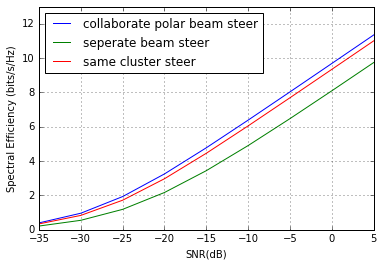

In [27]:
plt.plot(SNR_dB, (np.sum(R_cross,axis=1).real)/realization, label='collaborate polar beam steer')
plt.plot(SNR_dB, (np.sum(R_steer,axis=1).real)/realization, label='seperate beam steer')
plt.plot(SNR_dB, (np.sum(R_samecl,axis=1).real)/realization, label='same cluster steer')

plt.legend(loc='upper left')
plt.xlabel('SNR(dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.ylim(0,13)
plt.grid()
plt.show()